In [1]:
import numpy as np
import cupy as cp
from holotomocupy.holo import G, GT
from holotomocupy.shift import S, ST
from holotomocupy.recon_methods import CTFPurePhase, multiPaganin
from holotomocupy.utils import *
from holotomocupy.proc import remove_outliers
import h5py




astropy module not found
olefile module not found


# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 2048  # object size in each dimension
pad = n//8
npos= 36
z1c = -19.5e-3
# thickness of the coded aperture
code_thickness = 1.8e-6 #in m
# feature size
ill_feature_size = 2e-6 #in m

detector_pixelsize = 3e-6
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length
focusToDetectorDistance = 1.28  # [m]
sx0 = 3.7e-4
z1 = z1c
z1 = np.tile(z1, [npos])
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = np.abs(detector_pixelsize/magnifications[0]*2048/n)  # object voxel size

# sample size after demagnification
ne = 4608+2*pad
show = True

flg = f'{n}_{z1c}'
path = f'/data2/vnikitin/nfp_codes'
print(voxelsize)

4.570312499999999e-08


## Read data

In [3]:
data00 = np.zeros([1, npos, n, n], dtype='float32')
ref0 = np.zeros([1, npos, n, n], dtype='float32')
print(f'{path}/data_{0}_{flg}.tiff')
for k in range(npos):
    data00[:, k] = read_tiff(f'{path}/data_{k}_{flg}.tiff')[:1]
for k in range(npos):
    ref0[:, k] = read_tiff(f'{path}/ref_{k}_{flg}.tiff')[:]
code = np.load(f'{path}/code_{flg}.npy')
shifts_code = np.load(f'{path}/shifts_code_nfp_{flg}.npy')[:, :npos]


/data2/vnikitin/nfp_codes/data_0_2048_-0.0195.tiff


# Construct operators


In [4]:
def Lop(psi):
    psi = cp.array(psi)

    data = cp.zeros([psi.shape[0], npos, n, n], dtype='complex64')
    for i in range(npos):
        psir = psi[:,i].copy()       
        psir = G(psir, wavelength, voxelsize, distances[i])
        data[:, i] = psir[:, pad:n+pad, pad:n+pad]
    return data

def LTop(data):
    psi = cp.zeros([data.shape[0],npos, n+2*pad, n+2*pad], dtype='complex64')

    for j in range(npos):
        psir = cp.pad(data[:, j], ((0, 0), (pad, pad), (pad, pad))).astype('complex64')
        psir = GT(psir, wavelength, voxelsize, distances[j])        
        psi[:,j] = psir
    return psi

def Sop(psi):
    psi = cp.array(psi)

    data = cp.zeros([psi.shape[0], npos, n+2*pad, n+2*pad], dtype='complex64')
    for i in range(npos):
        psir = psi.copy()
    
        # shift and crop the code 
        psir = S(psir, shifts_code[:, i])
        nee = psir.shape[1]        
        data[:,i] = psir[:, nee//2-n//2-pad:nee//2+n//2+pad, nee//2-n//2-pad:nee//2+n//2+pad]
    return data

def STop(data):
    psi = cp.zeros([data.shape[0], ne, ne], dtype='complex64')

    for j in range(npos):
        psir = cp.pad(data[:,j],((0,0),(ne//2-n//2-pad,ne//2-n//2-pad),(ne//2-n//2-pad,ne//2-n//2-pad)))        
        psi += ST(psir,shifts_code[:,j])
    return psi


data = cp.array(data00)
arr1 = cp.pad(data[:,0],((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'symmetric')     
prb1 = cp.ones([1,n+2*pad,n+2*pad],dtype='complex64')
shifts_code = cp.array(shifts_code)
arr2 = Sop(arr1)
arr3 = STop(arr2)

arr4 = Lop(arr2)
arr5 = LTop(arr4)


print(f'{cp.sum(arr1*cp.conj(arr3))}==\n{cp.sum(arr2*cp.conj(arr2))}')
print(f'{cp.sum(arr2*cp.conj(arr5))}==\n{cp.sum(arr4*cp.conj(arr4))}')

(309580448-9.973982810974121j)==
(309580480-1.92062667853099e-11j)
(199966912-7.465576171875j)==
(199966896+0.00015021691797301173j)


#### Reconstruction with the CG (Carlsson) with Hessians

0) alpha=0.01431, err=2.57851e+06


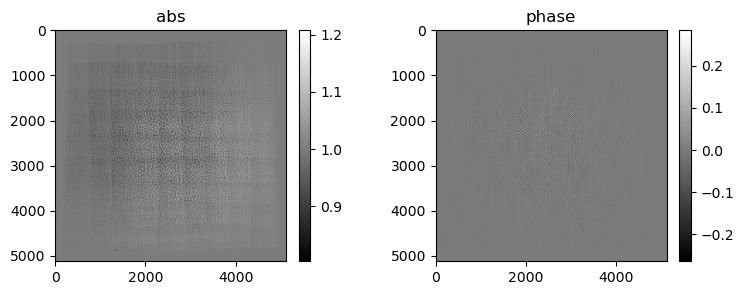

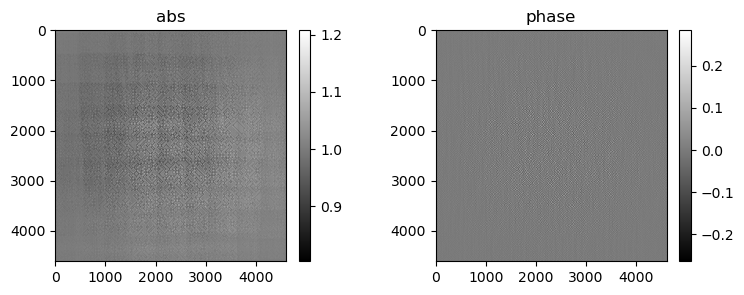

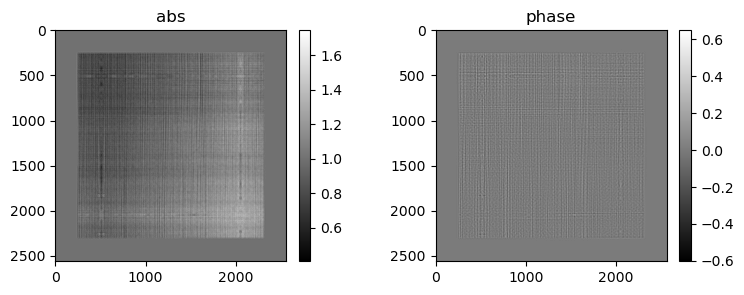

1) alpha=0.04224, err=1.31446e+06
2) alpha=0.01776, err=1.11051e+06
3) alpha=0.04448, err=9.23057e+05
4) alpha=0.02565, err=8.68276e+05
5) alpha=0.05869, err=7.90366e+05
6) alpha=0.05032, err=7.39397e+05
7) alpha=0.05306, err=6.64143e+05
8) alpha=0.02562, err=5.92818e+05
9) alpha=0.04452, err=4.91331e+05
10) alpha=0.03568, err=4.11497e+05
11) alpha=0.05624, err=3.27752e+05
12) alpha=0.02591, err=2.91931e+05
13) alpha=0.05657, err=2.44453e+05


In [5]:
def redot(a,b):
    return cp.sum(a.real*b.real+a.imag*b.imag)

def hessian2(Lpsi,Lpsi1,Lpsi2,data):
    l0 = Lpsi/cp.abs(Lpsi)
    d0 = data/cp.abs(Lpsi)
    v1 = redot(1-d0,cp.real(Lpsi1*cp.conj(Lpsi2)))
    v2 = redot(d0,cp.real(cp.conj(l0)*Lpsi1)*cp.real(cp.conj(l0)*Lpsi2))
    return 2*(v1+v2)

def minf(fpsi,data):
    f = np.linalg.norm(np.abs(fpsi)-data)**2
    return f

def cg_holo(data, init_psi,init_prb,  pars):
    
    data = np.sqrt(data)
    
    psi = init_psi.copy()
    prb = init_prb.copy()

    erra = np.zeros(pars['niter'])
    alphaa = np.zeros(pars['niter'])
    
    for i in range(pars['niter']):                                        
        
        Lpsi = Lop(Sop(psi)*prb)                
        gradx = 2*LTop(Lpsi-data*(Lpsi/cp.abs(Lpsi)))  
        
        gradpsi = STop(gradx*cp.conj(prb))                     
        gradprb = cp.sum(gradx*cp.conj(Sop(psi)),axis=1)
        
        if i==0:
            etapsi = -gradpsi
            etaprb = -gradprb
        else:
            Lpsi = Lop(Sop(psi)*prb)            
            Lksi = Lop(Sop(gradpsi)*prb+Sop(psi)*gradprb)   
            Leta = Lop(Sop(etapsi)*prb+Sop(psi)*etaprb)     
            # top
            top = hessian2(Lpsi,Lksi,Leta,data)
            top += redot(gradx,Sop(gradpsi)*etaprb+Sop(etapsi)*gradprb)
            # bottom
            bottom = hessian2(Lpsi,Leta,Leta,data)
            bottom += 2*redot(gradx,Sop(etapsi)*etaprb)

            beta = top/bottom
            
            etapsi = -gradpsi + beta*etapsi
            etaprb = -gradprb + beta*etaprb

        #top
        top = -redot(gradpsi,etapsi)-redot(gradprb,etaprb)
        # bottom
        Lpsi = Lop(Sop(psi)*prb)
        Leta = Lop(Sop(etapsi)*prb+Sop(psi)*etaprb)
        
        bottom = hessian2(Lpsi,Leta,Leta,data)
        bottom += 2*redot(gradx,Sop(etapsi)*etaprb)
        
        alpha = top/bottom

        psi += alpha*etapsi
        prb += alpha*etaprb

        if i % pars['err_step'] == 0:
            fpsi = Lop(Sop(psi)*prb)
            err = minf(fpsi,data)
            erra[i] = err
            alphaa[i] = alpha
            print(f'{i}) {alpha=:.5f}, {err=:1.5e}')

        if i % pars['vis_step'] == 0 and pars['vis_step']>0 :
            mshow_polar(psi[0],show)
            mshow_polar(psi[0,pad:-pad,pad:-pad],show)
            mshow_polar(prb[0],show)

    return psi,prb,erra,alphaa

# fully on gpu
rec_psi = cp.ones([1,ne,ne],dtype='complex64')#recMultiPaganin.copy()*0+1
data = cp.array(data00.copy())

rec_prb = cp.ones([1,n+2*pad,n+2*pad],dtype='complex64')
pars = {'niter':257, 'err_step': 1, 'vis_step': 16}
rec_psi,rec_prb,erra,alphaa = cg_holo(data,rec_psi,rec_prb, pars)

In [ ]:
np.save(f'{path}/rec_code_{flg}',rec_psi.get())
np.save(f'{path}/rec_prb_{flg}',rec_prb.get())
np.save(f'{path}/erra_{flg}',erra)
np.save(f'{path}/alphaa_{flg}',alphaa)